In [37]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.auto import tqdm, trange
from schwimmbad import MultiPool

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

Put pairs (i.e. disrupted binaries) on orbits in a grid and look at the separation at t=8 Gyr or whatever

In [3]:
pot = gp.CCompositePotential()
pot['disk'] = gp.MiyamotoNagaiPotential(
    m=6e10, a=3.5, b=0.28, units=galactic)
pot['halo'] = gp.NFWPotential.from_M200_c(
    M200=1e12*u.Msun, c=15, units=galactic)
pot['halo'] = gp.NFWPotential(
    m=pot['halo'].parameters['m'],
    r_s=pot['halo'].parameters['r_s'],
    b=0.95, c=0.9, units=galactic)

H = gp.Hamiltonian(pot)

### Compute a grid of orbits in x-z plane; vx=vz=0, set vy to keep E constant

In [5]:
from scipy.optimize import root

In [6]:
x0 = 15. * u.kpc
vy0 = 215 * u.km/u.s
fiducial_w0 = gd.PhaseSpacePosition(
    pos=[1., 0, 0] * x0,
    vel=[0, 1, 0] * vy0)
E0 = H.energy(fiducial_w0)[0].to( (u.km/u.s)**2 )

In [34]:
# _grid = np.arange(0, 30+1e-3, 0.2)
# xgrid, zgrid = map(np.ravel, np.meshgrid(_grid, _grid))

# _xgrid = np.arange(5, 20+1e-3, 0.25)
# _zgrid = np.arange(0, 7.5+1e-3, 0.25)

_xgrid = np.arange(5, 25+1e-3, 0.1)
_zgrid = np.arange(0, 15+1e-3, 0.1)

xgrid, zgrid = map(np.ravel, np.meshgrid(_xgrid, _zgrid)) 
Ngrid = len(xgrid)

def minfunc(vy, x, z):
    return 0.5*vy**2 + H.potential([x, 0, z]).to_value((u.km/u.s)**2) - E0.value

In [35]:
vygrid = np.full_like(xgrid, np.nan)
for n in trange(len(xgrid)):
    res = root(minfunc, 200., args=(xgrid[n], zgrid[n]))
    if res.success:
        vygrid[n] = res.x

In [45]:
mask, = np.where(np.isfinite(vygrid))

results_tbl = at.QTable()
results_tbl['dx_final'] = np.full(Ngrid, np.nan) * u.kpc
results_tbl['dv_final'] = np.full(Ngrid, np.nan) * u.km/u.s
results_tbl['dx_mean'] = np.full(Ngrid, np.nan) * u.kpc
results_tbl['dv_mean'] = np.full(Ngrid, np.nan) * u.km/u.s
results_tbl['period'] = np.full(Ngrid, np.nan) * u.Gyr

for n in tqdm(mask):
    if not np.isfinite(vygrid[n]):
        continue
        
    w0_1 = gd.PhaseSpacePosition(
        pos=[xgrid[n], 0, zgrid[n]] * u.kpc,
        vel=[0, vygrid[n], 0] * u.km/u.s)
    
    # Typical of binary disruption?
    w0_2 = gd.PhaseSpacePosition(w0_1.xyz + 1 * u.pc,
                                 w0_1.v_xyz + 1e-1 * u.km/u.s)

    w0s = gd.combine((w0_1, w0_2))
    
    # First: to guess orbital period
    orbits = H.integrate_orbit(w0s, dt=0.5*u.Myr, t1=-8*u.Gyr, t2=0*u.Gyr, 
                               Integrator=gi.DOPRI853Integrator)
    
    dpos = (orbits[:, 0].pos - orbits[:, 1].pos).norm()
    dvel = (orbits[:, 0].vel - orbits[:, 1].vel).norm()
    
    # Find index of ~1 orbital period ago
    P = orbits[:, 0].estimate_period()
    P_idx = np.abs(orbits.t - -P).argmin()
    
    results_tbl['dx_final'][n] = dpos[-1]
    results_tbl['dv_final'][n] = dvel[-1]
    results_tbl['dx_mean'][n] = np.mean(dpos[P_idx:])
    results_tbl['dv_mean'][n] = np.mean(dvel[P_idx:])
    results_tbl['period'][n] = P

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



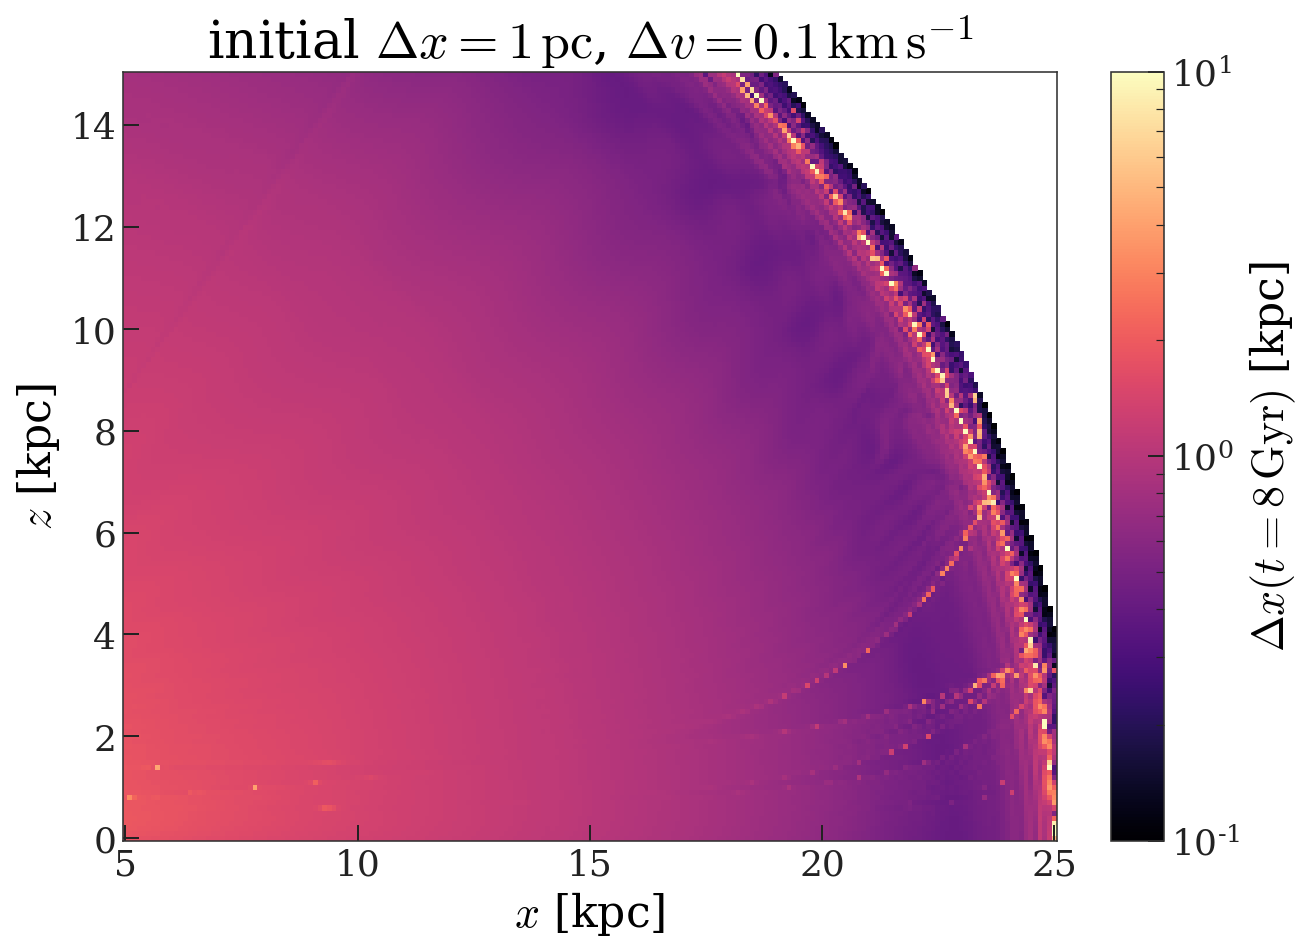

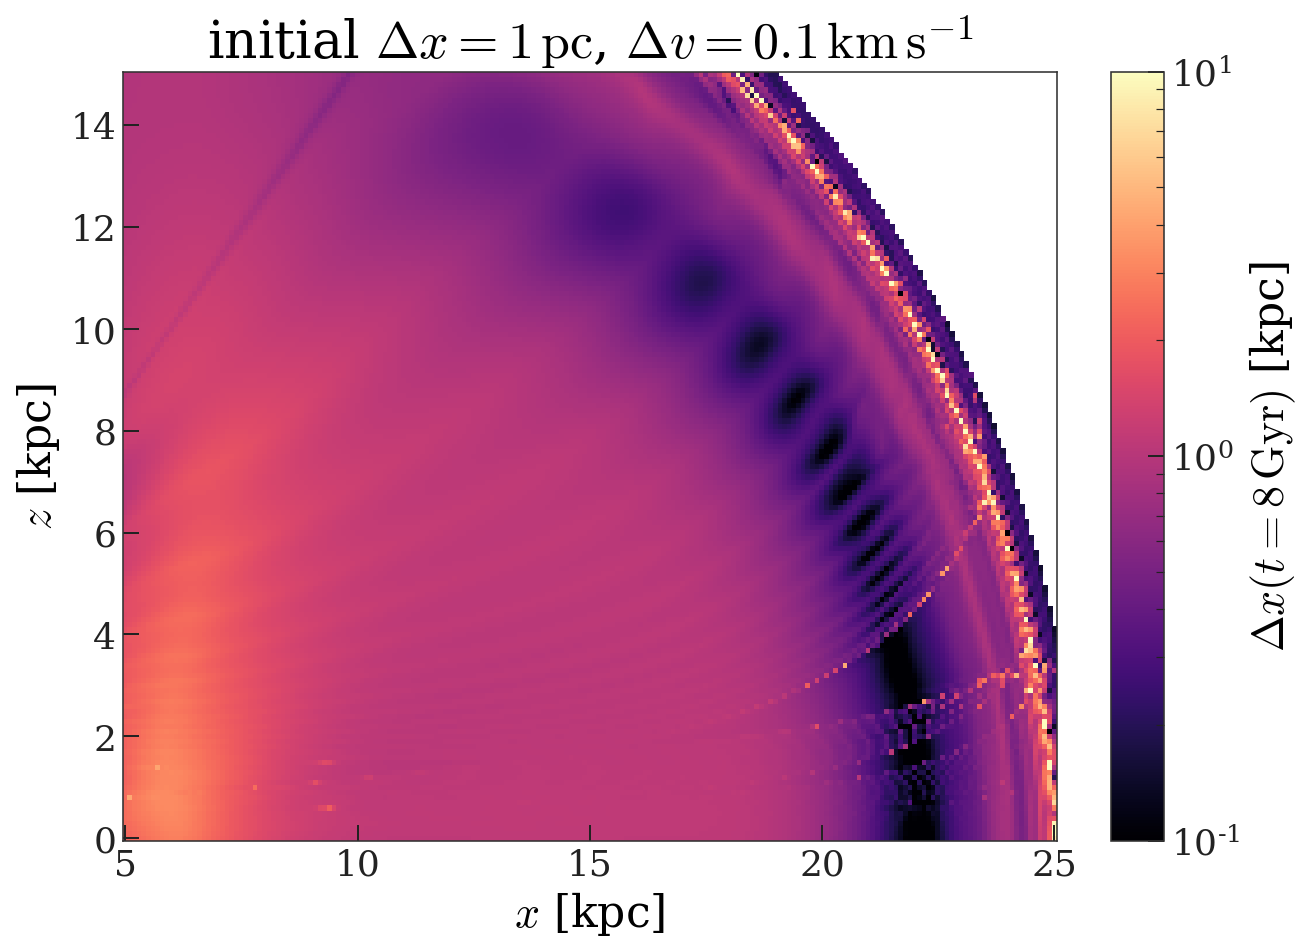

In [50]:
for c in [results_tbl['dx_mean'].to_value(u.kpc),
          results_tbl['dx_final'].to_value(u.kpc)]:

    fig, ax = plt.subplots(figsize=(9, 6.5),
                           constrained_layout=True)

    c = c.reshape((len(_zgrid), len(_xgrid)))
    cs = ax.pcolormesh(_xgrid, _zgrid, c, 
                       shading='auto',
                       norm=mpl.colors.LogNorm(vmin=1e-1, 
                                               vmax=10))
    ax.set_xlabel('$x$ [kpc]')
    ax.set_ylabel('$z$ [kpc]')

    cb = fig.colorbar(cs)
    cb.set_label(r'$\Delta x (t=8\,{\rm Gyr})$ [kpc]')

    ax.set_title(r'initial $\Delta x = 1\,{\rm pc}$, $\Delta v = 0.1\,{\rm km}\,{\rm s}^{-1}$')

    fig.set_facecolor('w')

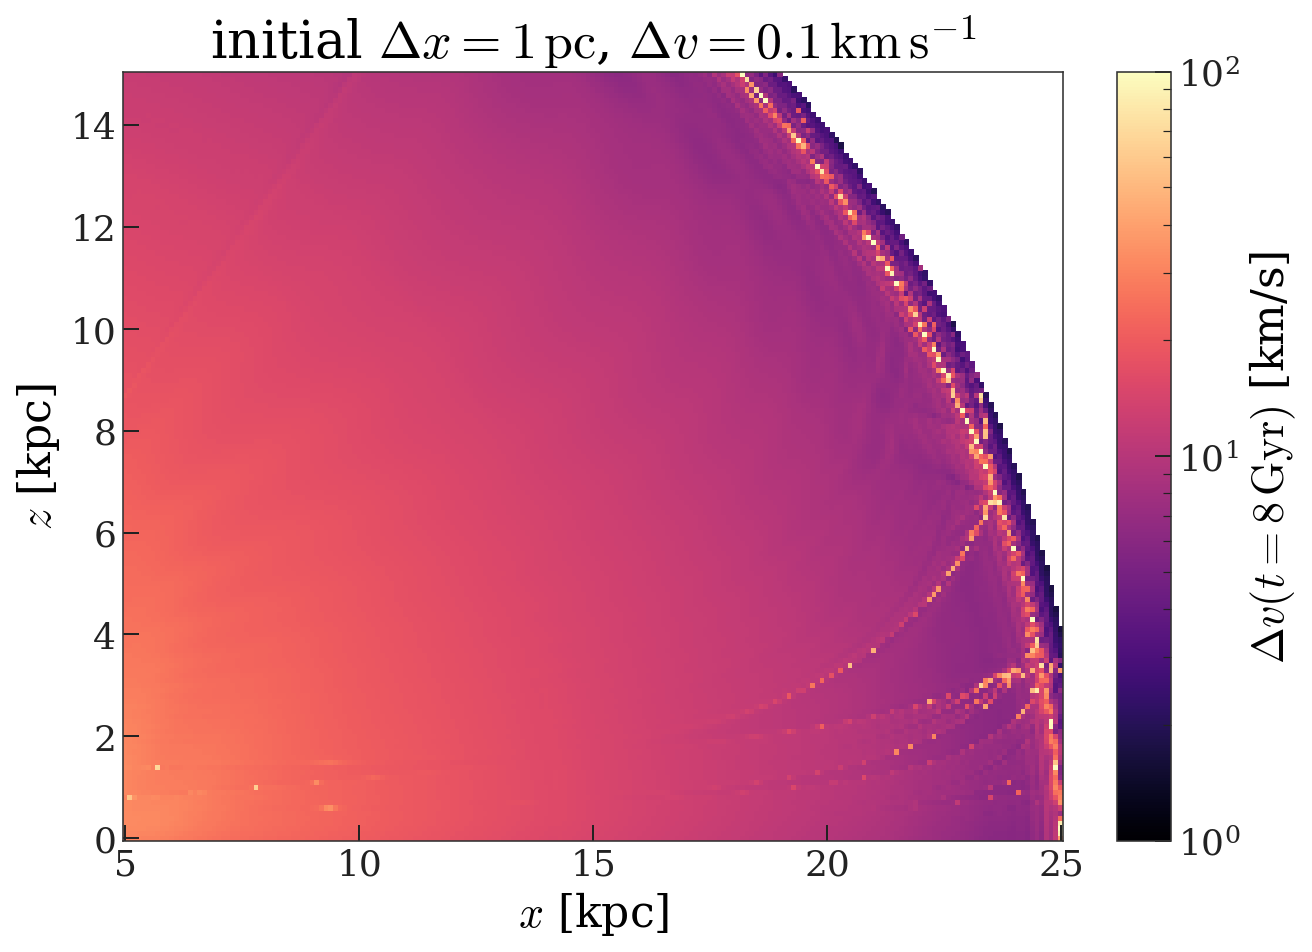

In [47]:
c = results_tbl['dv_mean'].to_value(u.km/u.s)
# np.log10(dxs.to_value(u.kpc) / periods.to_value(u.Gyr))
# c = np.log10(dvs.to_value(u.km/u.s))

fig, ax = plt.subplots(figsize=(9, 6.5),
                       constrained_layout=True)

c = c.reshape((len(_zgrid), len(_xgrid)))
cs = ax.pcolormesh(_xgrid, _zgrid, c, 
                   shading='auto',
                   norm=mpl.colors.LogNorm(vmin=1e0, 
                                           vmax=1e2))
ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

cb = fig.colorbar(cs)
cb.set_label(r'$\Delta v (t=8\,{\rm Gyr})$ [km/s]')

ax.set_title(r'initial $\Delta x = 1\,{\rm pc}$, $\Delta v = 0.1\,{\rm km}\,{\rm s}^{-1}$')

fig.set_facecolor('w')

---

### Initial explorations

In [264]:
# pot = gp.NFWPotential.from_M200_c(1e12*u.Msun, c=15, 
#                                   units=galactic)
# pot = gp.MilkyWayPotential()

pot = gp.LeeSutoTriaxialNFWPotential(v_c=229*u.km/u.s, r_s=15.5*u.kpc, 
                                     a=1, b=0.9, c=0.8, units=galactic)
# pot = gp.LeeSutoTriaxialNFWPotential(v_c=229*u.km/u.s, r_s=15.5*u.kpc, 
#                                      units=galactic)

In [265]:
w0_1 = gd.PhaseSpacePosition([10., 0, 2] * u.kpc,
                             [0, 0, 150] * u.km/u.s)
w0_2 = gd.PhaseSpacePosition(w0_1.xyz + 1 * u.pc,
                             w0_1.v_xyz + 1e-1 * u.km/u.s)
dpos_0 = (w0_1.pos - w0_2.pos).norm()
dvel_0 = (w0_1.vel - w0_2.vel).norm()

w0s = gd.combine((w0_1, w0_2))

In [266]:
# orbits = pot.integrate_orbit(w0s, dt=0.1, t1=0, t2=8*u.Gyr, 
orbits = pot.integrate_orbit(w0s, dt=1., t1=0, t2=100*u.Gyr, 
                             Integrator=gi.DOPRI853Integrator)
P = np.mean(orbits.estimate_period())
P_idx = np.abs(orbits.t - P).argmin()

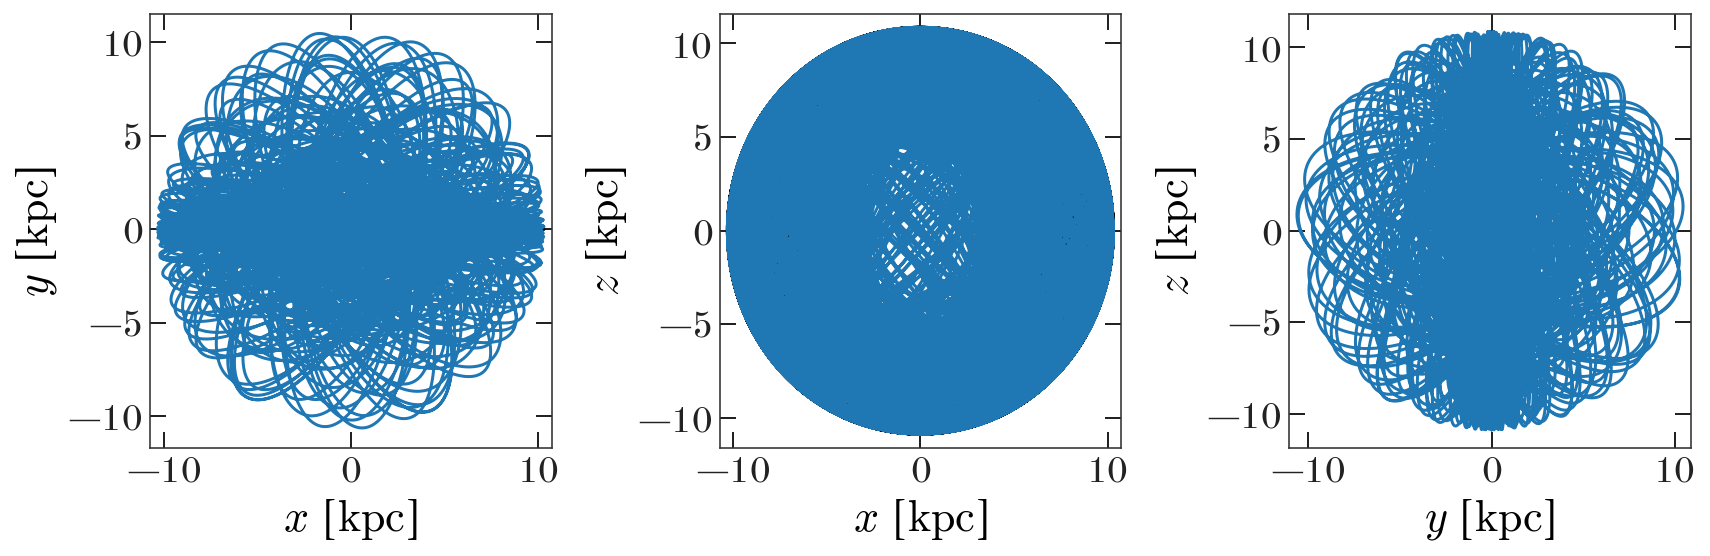

In [267]:
_ = orbits.plot()

In [268]:
dpos = (orbits[:, 0].pos - orbits[:, 1].pos).norm()
dvel = (orbits[:, 0].vel - orbits[:, 1].vel).norm()

In [269]:
# pos_norm = 1.*u.kpc
# vel_norm = 1.*u.km/u.s

# pos_norm = dpos_0
# vel_norm = dvel_0

pos_norm = dpos[P_idx]
vel_norm = dvel[P_idx]

dpos_norm = (dpos / pos_norm).decompose()
dvel_norm = (dvel / vel_norm).decompose()

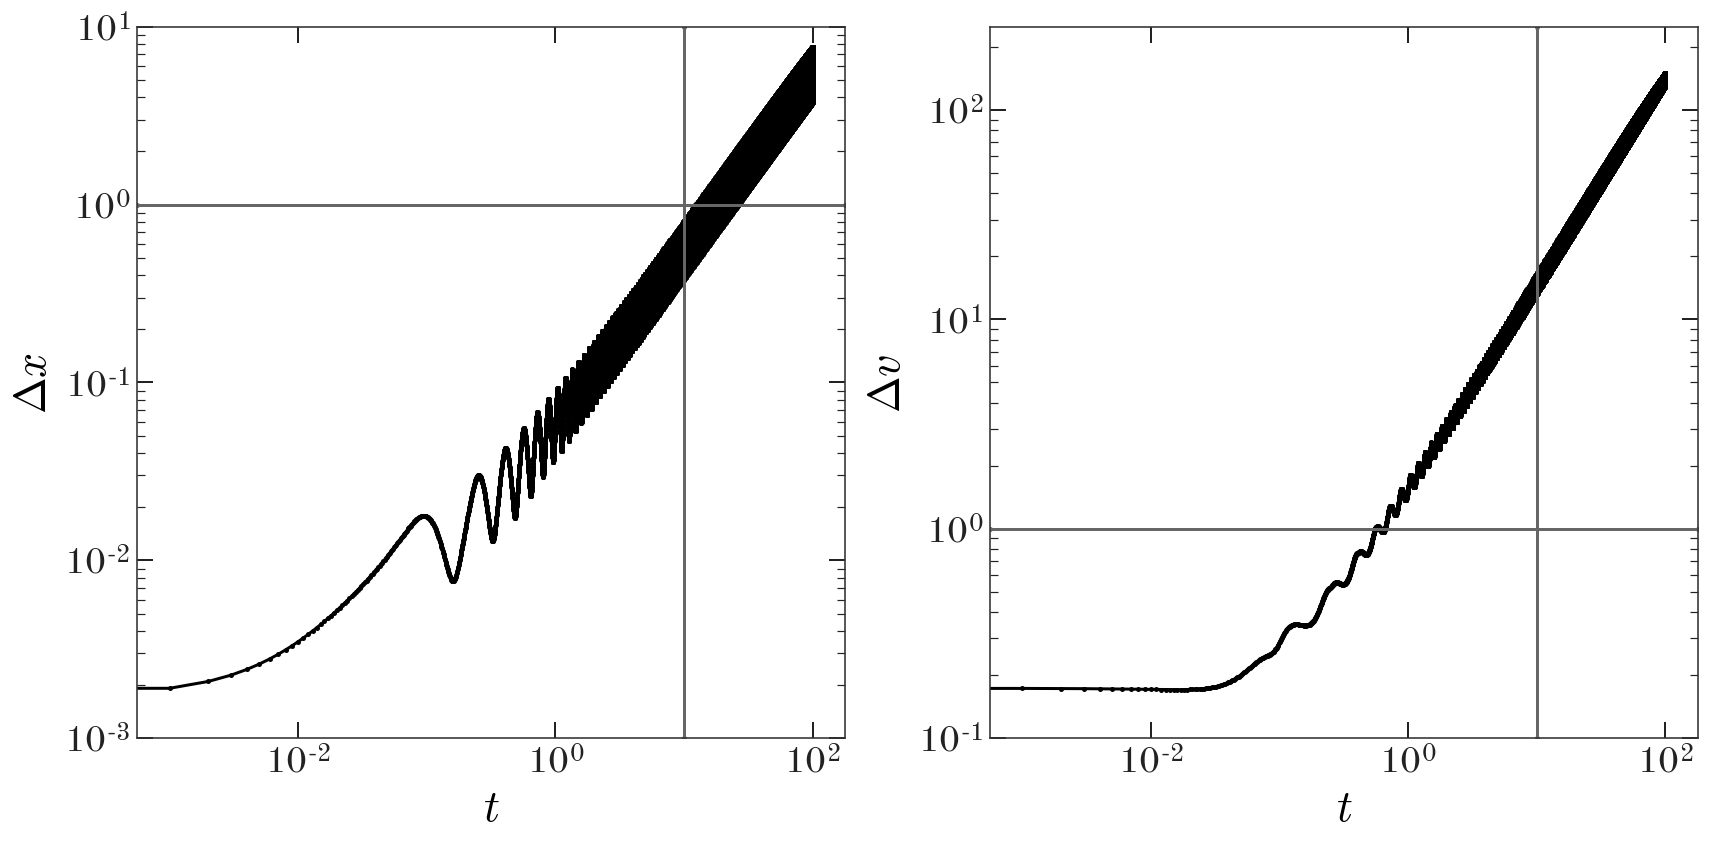

In [263]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True)

ax = axes[0]
ax.plot(orbits.t.to_value(u.Gyr), dpos.to_value(u.kpc))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta x$')
ax.set_yscale('log')

ax = axes[1]
ax.plot(orbits.t.to_value(u.Gyr), dvel.to_value(u.km/u.s))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta v$')
# ax.set_xlim(1, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')

axes[0].set_ylim(1e-3, 10)
axes[1].set_ylim(1e-1, 250)

for ax in axes:
    ax.axvline(10.)
    ax.axhline(1.)

fig.tight_layout()

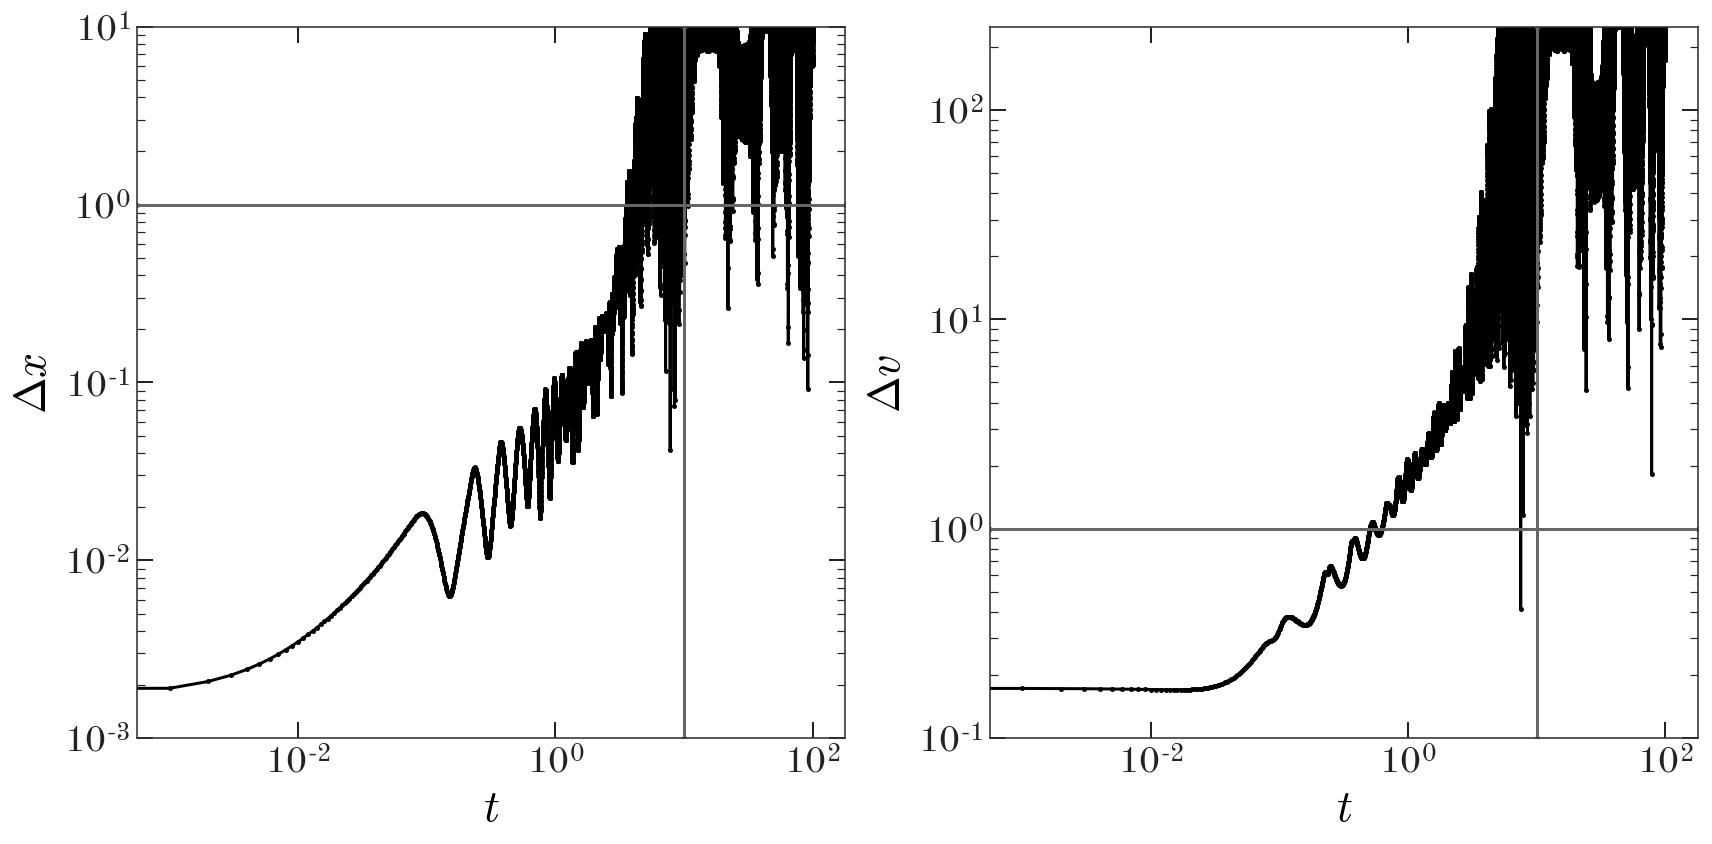

In [270]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True)

ax = axes[0]
ax.plot(orbits.t.to_value(u.Gyr), dpos.to_value(u.kpc))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta x$')
ax.set_yscale('log')

ax = axes[1]
ax.plot(orbits.t.to_value(u.Gyr), dvel.to_value(u.km/u.s))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta v$')
# ax.set_xlim(1, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')

axes[0].set_ylim(1e-3, 10)
axes[1].set_ylim(1e-1, 250)

for ax in axes:
    ax.axvline(10.)
    ax.axhline(1.)

fig.tight_layout()

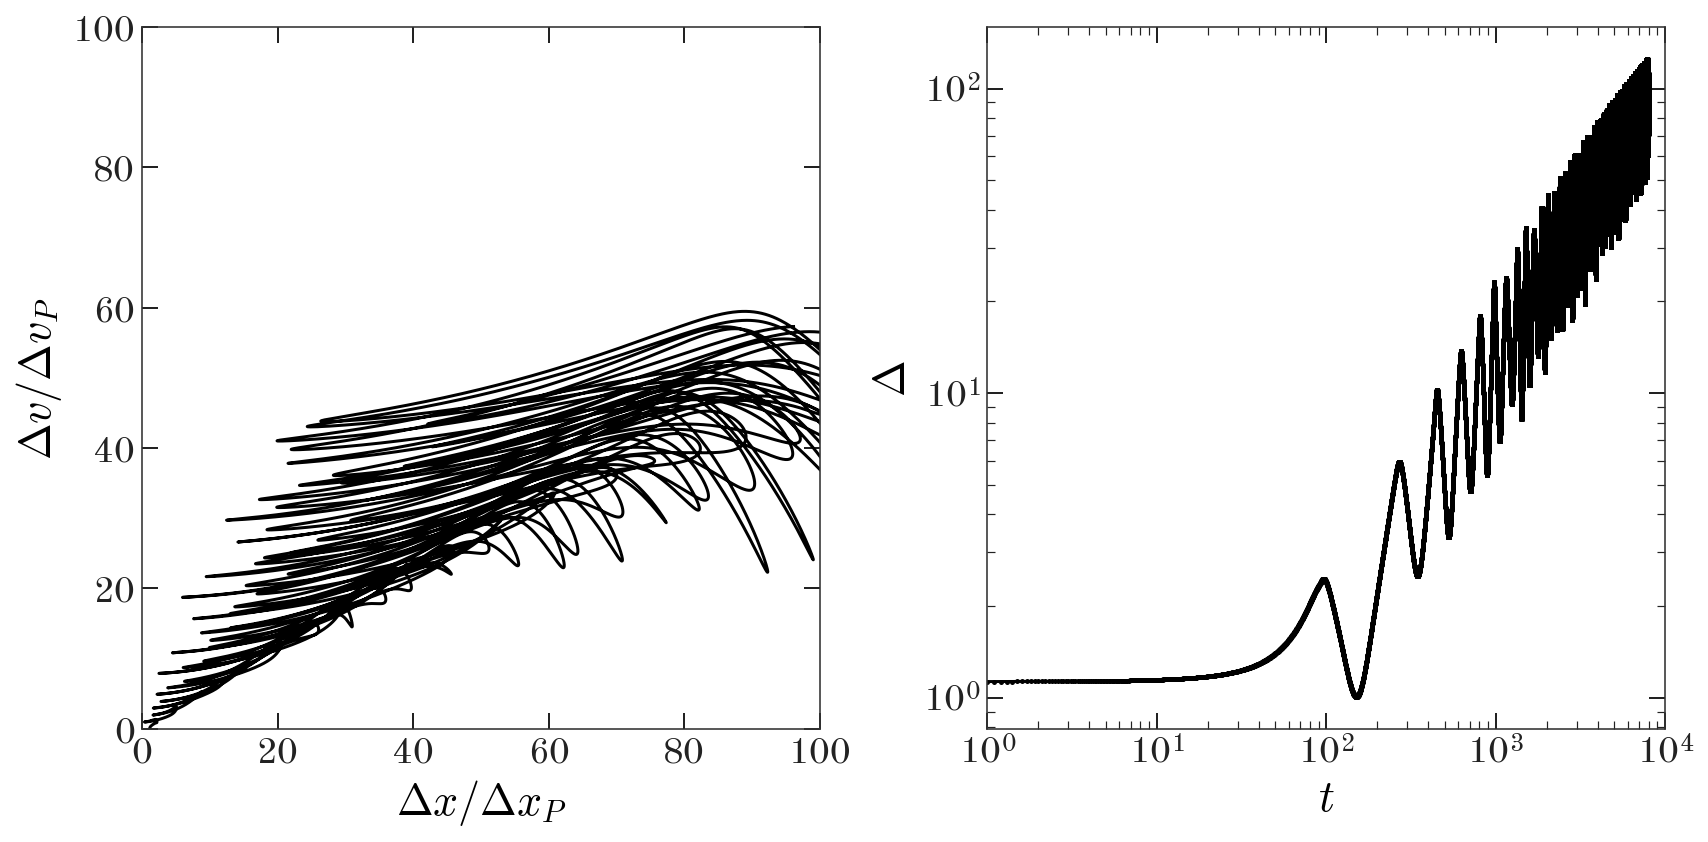

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.plot(dpos_norm, dvel_norm, marker='')
ax.set_xlabel(r'$\Delta x / \Delta x_P$')
ax.set_ylabel(r'$\Delta v / \Delta v_P$')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

ax = axes[1]
ax.plot(orbits.t.value, np.sqrt(dpos_norm**2 + dvel_norm**2))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta$')
ax.set_xlim(1, 1e4)
# ax.set_ylim(0, 50)
ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()